# IBM Dynamical Decoupling Optimizations with Superstaq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb)

[Dynamical decoupling (DD)](https://arxiv.org/abs/quant-ph/9803057) is an error mitigation technique used to suppress noise added to computation from system-environment interaction (i.e. decoherence error). DD is implemented during algorithm execution by adding special gate sequences that are equal to the identity operation in periods of qubit idling. Examples of DD sequences include XX, XY4, XY8, and UDD, among others.

Below is a brief tutorial on Superstaq dynamical decoupling optimizations for the IBM family of superconducting quantum devices. In the examples below, the CPMG sequence (XX) will be used.

Many [research articles](https://arxiv.org/abs/2207.03670) can be found that describe the variations and benefits of DD. For more information about IBM Quantum, visit their website [here](https://quantum-computing.ibm.com/).

There are many possible ways to determine how and where to place DD sequences within an idling window. We refer to these approaches as strategies. Superstaq supports the following dynamical decoupling strategies:

*Dynamic (default)*: Spaces pulses in a sequence based on sequence length, oblivious to sequences placed on neighboring qubits. <br>
*Static*: Inserts as many pulses in an idling duration as possible (not recommended for most circuits). <br>
*Static_context_aware*: Spacing each sequence's gates based on a specific value. <br>

All of the above strategies, by default, use the CPMG sequence.
Users have the ability to specify the dynamical decoupling strategy desired via the keyword argument `dd_strategy`.


## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

In [1]:
# Required Superstaq imports
try:
    import qiskit
    import qiskit_ibm_provider
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_ibm_provider
    import qiskit_superstaq as qss

# Optional imports
import os  # used if setting a token as an environment variable

In [2]:
!pip install qiskit-superstaq==0.4.21


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [3]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider(remote_host="https://127.0.0.1:5000", api_key=os.environ["SUPERSTAQ_API_KEY"])

This notebook will target IBM's 16-qubit Guadalupe device.

In [4]:
backend = provider.get_backend("ibmq_guadalupe_qpu")

/Users/paige/venv_superstaq/lib/python3.11/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


To submit jobs to the IBM machine, we will use an `IBMProvider`. This will require `qiskit-ibm-provider` and an accout on [IBM Quantum](https://quantum-computing.ibm.com/).

In [5]:
ibm_provider = qiskit_ibm_provider.IBMProvider()
ibm_backend = ibm_provider.get_backend("ibmq_guadalupe")

## Example 1: Circuit Compilation and DD Optimization with Superstaq

We will start by creating a circuit generator using Qiskit. In this example, we will use the Bernstein Vazirani (BV) algorithm to find the secret string of all ones ( i.e. '11...1'):

In [6]:
def create_bv(circuit_width: int):
    qc = qiskit.QuantumCircuit(circuit_width, circuit_width - 1)

    for i in range(circuit_width - 1):
        qc.h(i)
    qc.x(circuit_width - 1)
    qc.h(circuit_width - 1)

    for i in range(circuit_width - 1):
        qc.cx(i, circuit_width - 1)
    qc.barrier()

    for i in range(circuit_width):
        qc.h(i)

    for i in range(circuit_width - 1):
        qc.measure(i, i)

    return qc

We can draw the circuit using `qiskit`:

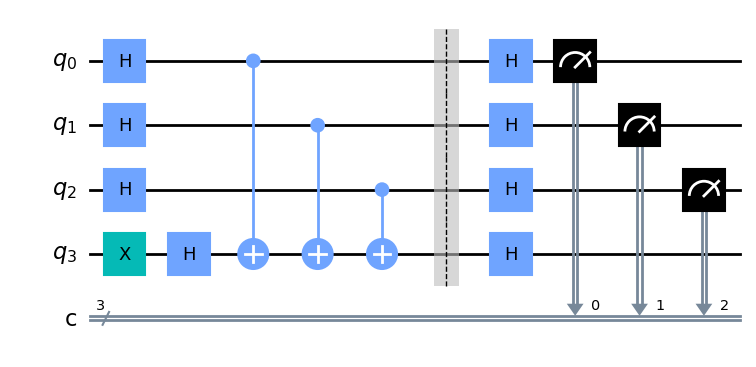

In [12]:
qc_4 = create_bv(4)
qc_4.draw("mpl")

Next, we will compile the logical circuit with Qiskit. Qiskit compilation will serve as a baseline that we use to evaluate Superstaq's performance.

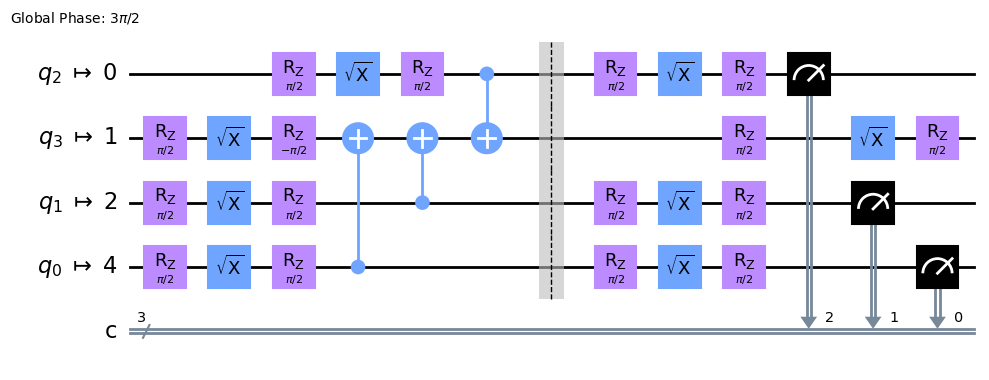

In [13]:
qiskit_qc_4_optimized = qiskit.transpile(qc_4, ibm_backend, optimization_level=3)
qiskit_qc_4_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Superstaq compilation transforms the circuit so that it uses optimized instructions. Here, on qubits with long idling durations we insert XX gates using our basic `static` strategy.

/Users/paige/venv_superstaq/lib/python3.11/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


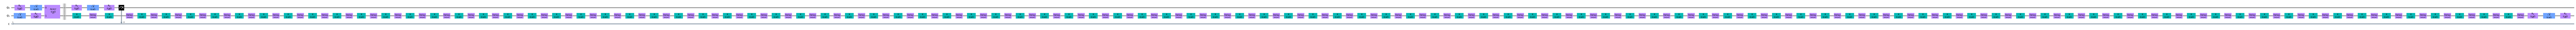

In [16]:
ss_qc_4_optimized = backend.compile(qc_2, dd_strategy="static", dynamical_decoupling=True)
ss_qc_4_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Below, we insert DD using the default `dynamic` strategy.

In [10]:
ss_qc_4_optimized = backend.compile(qc_4, dynamical_decoupling=True)
ss_qc_4_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

NameError: name 'qc_4' is not defined

And now, we compile with DD using our third strategy `static_context_aware`.

In [ ]:
ss_qc_4_optimized = backend.compile(qc_4, dd_strategy="static_context_aware", dynamical_decoupling=True)
ss_qc_4_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

## Example 2: Real Quantum Machine Results

Here, we will show how Superstaq compares to Qiskit's `optimization_level = 3` on modestly sized circuits. First, let's create a seven-qubit BV benchmark:

In [ ]:
qc_7 = create_bv(7)
qc_7.draw("mpl")

Qiskit `optimization_level = 3` transpilation:

In [ ]:
qiskit_qc_7_optimized = qiskit.transpile(qc_7, ibm_backend, optimization_level=3)
qiskit_qc_7_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Superstaq optimized compilation with `dynamic` DD:

In [ ]:
ss_qc_7_optimized = backend.compile(qc_7, dynamical_decoupling=True)
ss_qc_7_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Finally, circuit execution on IBM Guadalupe:

In [ ]:
job_7 = ibm_backend.run([ss_qc_7_optimized.pulse_gate_circuit, qiskit_qc_7_optimized], shots=4000)

In [ ]:
counts_7 = job_7.result().get_counts()
qiskit.visualization.plot_histogram(
    counts_7, legend=["ss-dd", "qiskit"], number_to_keep=10, figsize=(11, 5)
)

The correct answer is '111111,' and we can see that Superstaq offers dramatic improvements! More than 3.1x in terms of probability of success and about 6.5x in terms of relative strength.

Let's try again with nine qubits!

First, create:

In [ ]:
qc_9 = create_bv(9)
qc_9.draw("mpl")

Second, Qiskit transpile:

In [ ]:
qiskit_qc_9_optimized = qiskit.transpile(qc_9, ibm_backend, optimization_level=3)
qiskit_qc_9_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Third, Superstaq optimize with DD:

In [ ]:
ss_qc_9_optimized = backend.compile(qc_9, dynamical_decoupling=True)
ss_qc_9_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Last, real machine run.

In [ ]:
job_9 = ibm_backend.run([ss_qc_9_optimized.pulse_gate_circuit, qiskit_qc_9_optimized], shots=4000)

In [ ]:
counts_9 = job_9.result().get_counts()
qiskit.visualization.plot_histogram(
    counts_9, legend=["ss-dd", "qiskit"], number_to_keep=10, figsize=(11, 5)
)

In this case, Superstaq with DD is once again able to provide outstanding improvement -- more than 12.6x in terms of probability of '11111111' success and about 25.3x in terms of relative strength.